# ez-optimize Examples

This notebook provides examples for the `ez-optimize` library, demonstrating core and advanced features. For a quick introduction, see the [README.md](../README.md). This is the beset form of documentation until I generate a full API reference. 

View on nbviewer: [examples.ipynb (nbviewer.org)](https://nbviewer.org/github/qthedoc/ez-optimize/blob/main/docs/examples.ipynb)

## Table of Contents
1. [Keyword-Based Optimization](#example-1)
2. [Keyword-Based Bounds](#example-2)
3. [Maximization](#example-3)
4. [Dictionary with Array Value](#example-4)
5. [Passing Extra Kwargs to User Function](#example-5)
6. [Using Callback for Optimization Path Visualization](#example-6)
7. [Full Manual Control](#example-7)
8. [Typical Array-Based Optimizer Usage (5 Variables with Bounds)](#example-8)

In [1]:
# Setup: Import libraries and define example functions
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from ez_optimize import minimize, OptimizationProblem

# 2D Rosenbrock function (known minimum: value=0 @ x=1, y=1, a=1, b=100)
def rosenbrock_2d(x, y, a=1, b=100):
    return (a - x)**2 + b * (y - x**2)**2

# N-Dimensional Rosenbrock for arrays
def rosenbrock(x, a=1, b=100):
    return sum(a * (x[1:] - x[:-1] ** 2.0) ** 2.0 + (1 - x[:-1]) ** 2.0) + b

### <span id='example-1'>Example 1: Keyword-Based Optimization</span>

**Goal**: Minimize the Rosenbrock function using keyword-based parameters.

How it works: When you set x0 as a dict and define an objective function that accepts matching keyword arguments, `ez-optimize` will automatically flatten the parameters for SciPy and restore the original structure in results.

In [2]:
x0 = {'x': 1.3, 'y': 0.7}

result = minimize(rosenbrock_2d, x0, method='BFGS')

print(f"Optimal x: {result.x}")
print(f"Optimal value: {result.fun}")

Optimal x: {'x': 0.9999955166906928, 'y': 0.9999910211409269}
Optimal value: 2.0115094474352237e-11


### <span id='example-2'>Example 2: Keyword-Based Bounds</span>

**Goal**: Optimize a 2D Rosenbrock function with keyword parameters and bounds.

In [3]:
x0 = {'x': 1.3, 'y': 0.7}
bounds = {'x': (0, 2), 'y': (0, 2)}

result = minimize(rosenbrock_2d, x0, kwargs=dict(a=1, b=100), method='SLSQP', bounds=bounds)

print(f"Optimal x: {result.x}")
print(f"Optimal value: {result.fun}")

Optimal x: {'x': 0.9999105552050612, 'y': 0.9998144563076826}
Optimal value: 1.2438732728332328e-08


### <span id='example-3'>Example 3: Maximization</span>

**Goal**: Maximize a function using `direction='max'`.

How it works: When `direction='max'`, `ez-optimize` negates the objective function for SciPy and restores the original sign in results, allowing you to maximize without changing your function definition.

In [4]:
def quadratic(x):
    return - (x - 1)**2

result = minimize(quadratic, {'x': 0.}, method='SLSQP', direction='max')

print(f"Optimal x: {result.x}")
print(f"Optimal value: {result.fun}")

Optimal x: {'x': 1.0000000000000002}
Optimal value: -4.930380657631324e-32


### <span id='example-4'>Example 4: Dictionary with Array Value</span>

**Goal**: Optimize with a dictionary containing an array parameter.

Under the hood `ez-optimize` will flatten all individual values into a single array for SciPy and restore the original structure in results.

In [5]:
x0 = {'x': np.array([1.3, 0.7, 0.8, 1.9, 1.2])}

result = minimize(partial(rosenbrock, a=1, b=100), x0, method='BFGS')

print(f"Optimal x: {result.x}")
print(f"Optimal value: {result.fun}")

Optimal x: {'x': array([1.00000002, 0.99999994, 1.00000006, 1.00000015, 1.00000024])}
Optimal value: 100.00000000000009


### <span id='example-5'>Example 5: Passing Extra Kwargs to User Function</span>

**Goal**: Pass additional keyword arguments to the user function.

How it works: Just like *args can be passed to user func with SciPy minimize, **kwargs can be passed to user func.
Note: 
- When x0 is a dict (dict mode), passing positional `args=` is not allowed.
- When x0 is an array (array mode), you can pass `args=` and `kwargs=`.


In [6]:
x0 = {'x': 1.3, 'y': 0.7}
kwargs={'a': 2, 'b': 200} # altered rosenbrock

result = minimize(rosenbrock_2d, x0, method='nelder-mead', kwargs=kwargs)
print(f"Optimal x: {result.x}")
print(f"Optimal fun: {result.fun}")

Optimal x: {'x': 2.000007684990501, 'y': 4.000031014923428}
Optimal fun: 7.417334104066787e-11


### <span id='example-6'>Example 6: Using Callback for Optimization Path Visualization</span>

**Goal**: Use callback in dict mode to track and plot the optimization path for 2D Rosenbrock.

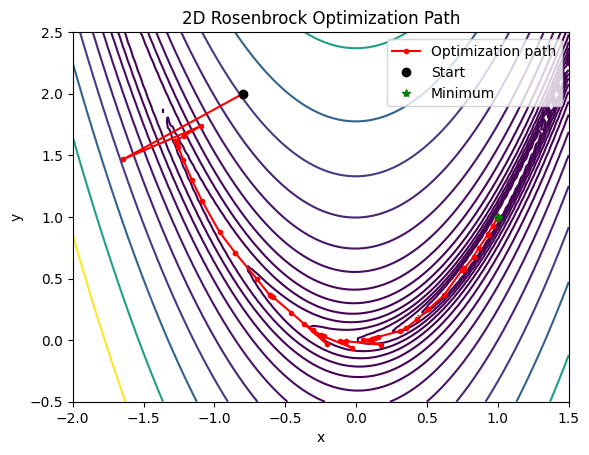

In [7]:
history = []

def callback(intermediate_result):
    history.append((intermediate_result.x['x'], intermediate_result.x['y'], intermediate_result.fun))

x0 = {'x': -0.8, 'y': 2.0}

result = minimize(rosenbrock_2d, x0, method='trust-constr', callback=callback)

# Plot the path
path = np.array(history)
x = np.linspace(-2, 1.5, 100)
y = np.linspace(-0.5, 2.5, 100)
X, Y = np.meshgrid(x, y)
Z = rosenbrock_2d(X, Y, 1, 100)

plt.contour(X, Y, Z, levels=np.logspace(-0.5, 3, 15), cmap='viridis')
plt.plot(path[:, 0], path[:, 1], 'r.-', label='Optimization path')
plt.plot(x0['x'], x0['y'], 'ko', label='Start')
plt.plot(1, 1, 'g*', label='Minimum')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Rosenbrock Optimization Path')
plt.show()

### <span id='example-7'>Example 7: Full Manual Control</span>

**Goal**: For advanced manual control, use the `OptimizationProblem` class directly. This also serves as a look under the hood for how `minimize` works.

TODO: show how this can be used to slip props directly into scipy or to implement a custom optimization loop

In [8]:
from scipy.optimize import minimize as scipy_minimize

def objective(a, b, c):
    return a**2 + b**2 + c**2

x0 = {'a': 1.0, 'b': 2.0, 'c': 3.0}
bounds = {'a': (0, 5), 'b': (0, 5), 'c': (0, 5)}

# Define the optimization problem
problem = OptimizationProblem(objective, x0, method='SLSQP', bounds=bounds)

# Run SciPy method directly, passing in the arguments prepared by the OptimizationProblem
scipy_result = scipy_minimize(**problem.scipy.get_minimize_args())

# Use the OptimizationProblem to interpret the result back into our structured format
result = problem.scipy.interpret_result(scipy_result)

print(f"Optimal parameters: {result.x}")
print(f"Optimal value: {result.fun}")

Optimal parameters: {'a': 1.7763568394002505e-15, 'b': 4.440892098500626e-16, 'c': 0.0}
Optimal value: 3.3526588471893e-30


### <span id='example-8'>Example 8: Typical Array-Based Optimizer Usage (5 Variables with Bounds)</span>

**Goal**: Show that `ez-optimize` can still be used like a typical SciPy optimizer with arrays and bounds.

In [9]:
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
bounds = [(0, 2), (0, 2), (0, 2), (0, 2), (0, 2)]

result = minimize(rosenbrock, x0, method='SLSQP', args=(100, 0), bounds=bounds)

print(f"Optimal x: {result.x}")
print(f"Optimal value: {result.fun}")

Optimal x: [1.00004303 1.0000684  1.00017009 1.0003454  1.0006957 ]
Optimal value: 3.0170901914560603e-07
